## 📘 04 - Modelado de Predicción de Ventas e Inventario

In [95]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.model_selection import learning_curve
import scipy.stats as stats
import shap

sys.path.append(os.path.abspath('../'))

from src.modeling import entrenar_modelos_regresion
from src.modeling import entrenar_modelos
from src.modeling import evaluar_modelos

Cargar datos procesados

In [96]:

fct_encoded_general = pd.read_csv('../datasets/processed/fct_encoded_general.csv')
fct_encoded_producto = pd.read_csv('../datasets/processed/fct_encoded_producto.csv')

Separar features y variable objetivo

In [97]:

X_general = fct_encoded_general.drop(columns=['QUANTITY'])
y_general = fct_encoded_general['QUANTITY']

X_producto = fct_encoded_producto.drop(columns=['QUANTITY'])
y_producto = fct_encoded_producto['QUANTITY']

Label Encoding para PRODUCTID si aún está presente

In [98]:
if 'PRODUCTID' in X_producto.columns:
    le = LabelEncoder()
    X_producto['PRODUCTID'] = le.fit_transform(X_producto['PRODUCTID'])



In [99]:
modelos = entrenar_modelos(X_train_g_clean, y_train_g)
resultados = evaluar_modelos(modelos, X_test_g_clean, y_test_g)


c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

In [100]:
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_general, y_general, test_size=0.2, random_state=42)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_producto, y_producto, test_size=0.2, random_state=42)

In [101]:
def preparar_datos(df):
    X = df.drop(columns=['QUANTITY'])
    y = df['QUANTITY']
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train_g, X_test_g, y_train_g, y_test_g = preparar_datos(fct_encoded_general)
X_train_p, X_test_p, y_train_p, y_test_p = preparar_datos(fct_encoded_producto)

Verificar y eliminar columnas no numéricas antes de entrenar

In [102]:
columnas_no_numericas_g = X_train_g.select_dtypes(include=['object']).columns
if len(columnas_no_numericas_g) > 0:
    print("Columnas no numéricas en versión general:", columnas_no_numericas_g.tolist())
    X_train_g = X_train_g.drop(columns=columnas_no_numericas_g)
    X_test_g = X_test_g.drop(columns=columnas_no_numericas_g)

columnas_no_numericas_p = X_train_p.select_dtypes(include=['object']).columns
if len(columnas_no_numericas_p) > 0:
    print("Columnas no numéricas en versión producto:", columnas_no_numericas_p.tolist())
    X_train_p = X_train_p.drop(columns=columnas_no_numericas_p)
    X_test_p = X_test_p.drop(columns=columnas_no_numericas_p)

Columnas no numéricas en versión general: ['PRODUCTID', 'DELIVERYDATE', 'PRODCATEGORYID', 'SEMANA']
Columnas no numéricas en versión producto: ['DELIVERYDATE', 'PRODCATEGORYID', 'SEMANA']


Evaluación y conversion de datos para el DataFrame

In [103]:
from sklearn.inspection import PartialDependenceDisplay
from IPython.display import display

resumen_resultados = entrenar_modelos_regresion(X_train_g_clean, X_test_g_clean, y_train_g, y_test_g)

df_resumen = pd.DataFrame(resumen_resultados).T.sort_values(by='RMSE')
display(df_resumen)

c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

,MAE,RMSE,R2
DecisionTree,0.003633,0.035504,0.998702
RandomForest,0.015141,0.035856,0.998676
GradientBoosting,0.091658,0.118688,0.985493
LinearRegression,0.548454,0.697852,0.498493


Entrenamiento de modelos y comparativa entre la predicción general y usando PRODUCTID

In [104]:

resultados_general = entrenar_modelos_regresion(X_train_g, X_test_g, y_train_g, y_test_g)
resultados_producto = entrenar_modelos_regresion(X_train_p, X_test_p, y_train_p, y_test_p)

df_general = pd.DataFrame(resultados_general).T
df_producto = pd.DataFrame(resultados_producto).T

print("Resultados - Comparativa general de modelos (predicción general)")
display(df_general.sort_values('RMSE'))

print("Resultados - Comparativa por producto (con PRODUCTID codificado)")
display(df_producto.sort_values('RMSE'))


c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

Resultados - Comparativa general de modelos (predicción general)


c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

,MAE,RMSE,R2
DecisionTree,0.003633,0.035504,0.998702
RandomForest,0.015141,0.035856,0.998676
GradientBoosting,0.091658,0.118688,0.985493
LinearRegression,0.548454,0.697852,0.498493


Resultados - Comparativa por producto (con PRODUCTID codificado)


,MAE,RMSE,R2
DecisionTree,0.003633,0.035504,0.998702
RandomForest,0.015141,0.035856,0.998676
GradientBoosting,0.091658,0.118688,0.985493
LinearRegression,0.548454,0.697852,0.498493


In [105]:
print(X_train_g.select_dtypes(include='object').columns)


Index([], dtype='object')


## Visualizaciones Gráficas de los Modelos

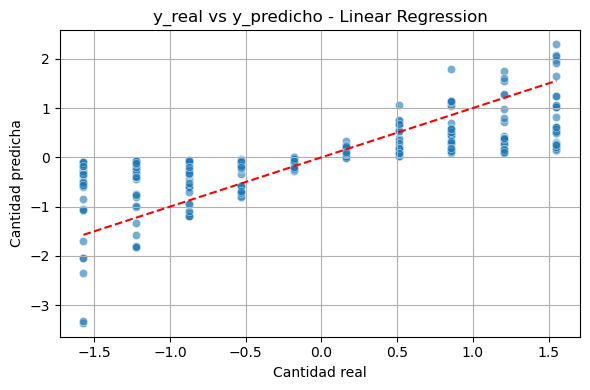

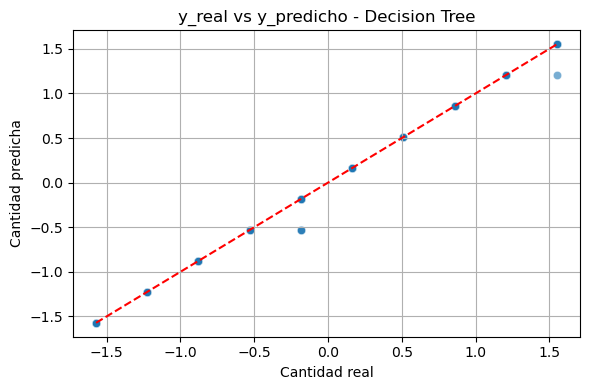

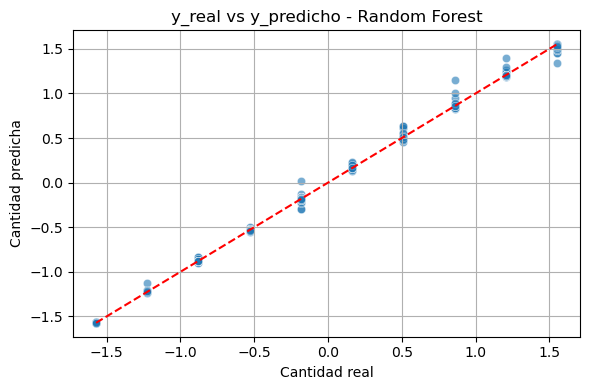

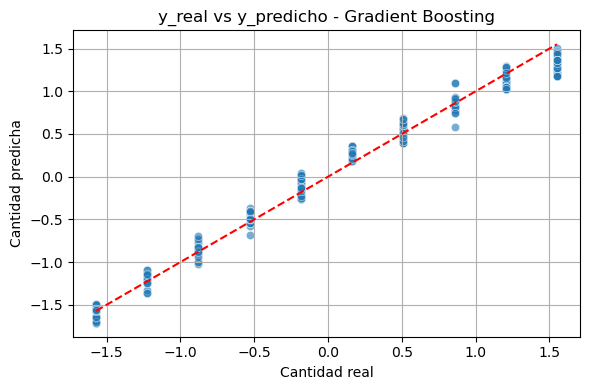

In [106]:
X_train_g_clean = X_train_g.select_dtypes(include=['int64', 'float64']).copy()
X_test_g_clean = X_test_g.select_dtypes(include=['int64', 'float64']).copy()

modelos = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

for nombre, modelo in modelos.items():
    modelo.fit(X_train_g_clean, y_train_g)
    y_pred = modelo.predict(X_test_g_clean)

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test_g, y=y_pred, alpha=0.6)
    plt.xlabel("Cantidad real")
    plt.ylabel("Cantidad predicha")
    plt.title(f"y_real vs y_predicho - {nombre}")
    plt.plot([y_test_g.min(), y_test_g.max()], [y_test_g.min(), y_test_g.max()], 'r--')  # línea ideal
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [107]:

modelos = entrenar_modelos(X_train_g_clean, y_train_g)

modelos['RandomForest'].feature_importances_
modelos['GradientBoosting'].predict(X_test_g_clean)


array([-1.50326518,  0.30711584,  0.53039255, -1.56980311,  1.28469157,
       -0.88677467,  0.80334792, -0.0697041 ,  0.80334792, -0.47988092,
       -0.20073076, -1.547236  ,  0.00283407, -0.51854223,  0.3631021 ,
       -0.58326871, -1.17241118, -1.15442461,  1.27425378, -1.14111827,
       -0.13340275, -0.8395535 ,  0.86361383, -1.55547367, -1.14111827,
        0.1822326 ,  0.90924189, -1.50052473, -1.15442461, -0.03509247,
       -0.25954515,  1.14960957, -1.64867053, -0.45265115, -1.20203884,
       -0.74106606,  1.33900375,  0.21137027,  1.24617184, -1.21874836,
       -0.88895101, -0.25954515, -1.56817359, -0.15245895,  1.11415381,
       -0.40011414,  0.24983785,  1.26192363,  1.43251431, -0.49634507,
       -1.55618955,  1.37176994, -0.12354692, -1.55547367, -1.65273876,
       -0.10841176,  0.18508723, -0.46461376, -0.24463255, -0.54044487,
        0.90695809,  0.44795453, -0.43936421,  1.47302645, -0.06302411,
       -1.71119393,  0.61293782,  0.79566776, -0.82761471,  0.61

### Relevant Featuters

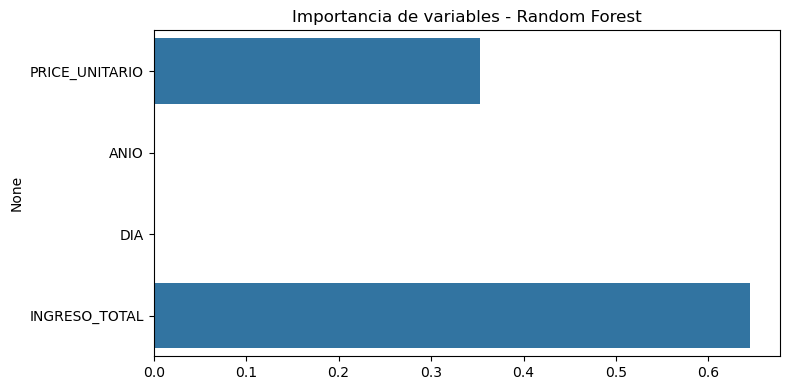

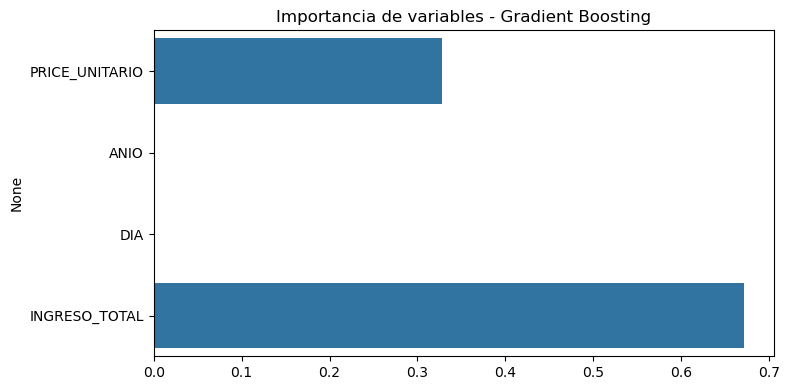

In [108]:
importances_rf = modelos['RandomForest'].feature_importances_
importances_gb = modelos['GradientBoosting'].feature_importances_

features = X_train_g_clean.columns

# Random Forest
plt.figure(figsize=(8, 4))
sns.barplot(x=importances_rf, y=features)
plt.title("Importancia de variables - Random Forest")
plt.tight_layout()
plt.show()

# Gradient Boosting
plt.figure(figsize=(8, 4))
sns.barplot(x=importances_gb, y=features)
plt.title("Importancia de variables - Gradient Boosting")
plt.tight_layout()
plt.show()


## Random Forest y Gradient Boosting — Importancia de Variables
INGRESO_TOTAL es la variable más importante en ambos modelos para predecir la cantidad (QUANTITY).

Esto indica que el ingreso generado por transacción tiene una relación directa con la cantidad vendida.

PRICE_UNITARIO también tiene una influencia relevante, aunque menor.

Esto sugiere que el precio del producto impacta en la cantidad vendida, posiblemente por efectos de demanda.

DIA y ANIO presentan una importancia nula o muy baja.

Esto puede significar que no aportan información significativa para la predicción, o que su efecto ya está representado por otras variables como MES o INGRESO_TOTAL.

### Partial Dependece Plot

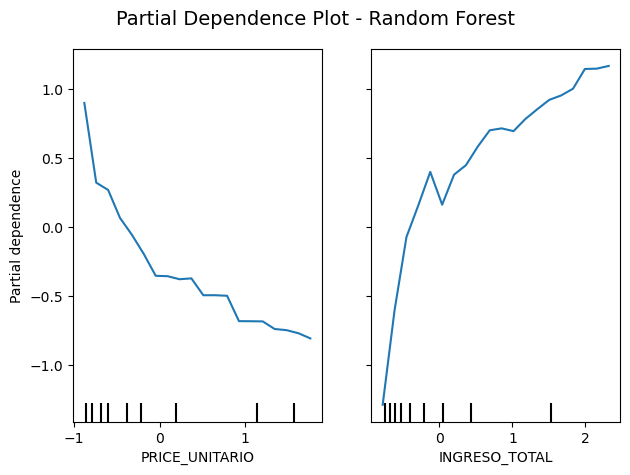

In [109]:
rf_model = modelos['RandomForest'] 
features_pdp = ['PRICE_UNITARIO', 'INGRESO_TOTAL'] 


X_train_num = X_train_g.select_dtypes(include=['number'])

display = PartialDependenceDisplay.from_estimator(
    rf_model,
    X_train_num,
    features_pdp,
    kind="average",
    grid_resolution=20
)

plt.suptitle("Partial Dependence Plot - Random Forest", fontsize=14)
plt.tight_layout()
plt.show()


## PDP Random Forest
PRICE_UNITARIO:

A medida que el precio unitario aumenta, la cantidad predicha (QUANTITY) tiende a disminuir.

Esto refleja un comportamiento típico del consumidor: precios más altos llevan a menor demanda.

INGRESO_TOTAL:

A mayor ingreso total, la cantidad predicha también aumenta.

Esto es coherente, ya que mayores ingresos suelen estar asociados a mayores volúmenes de venta.

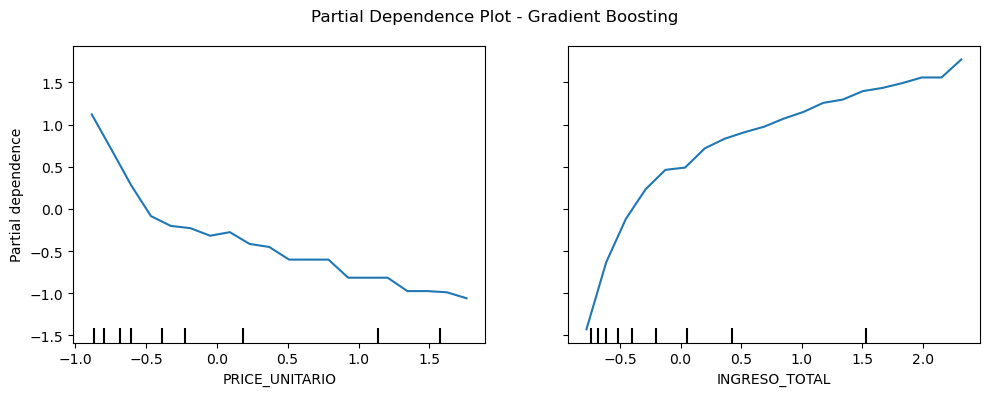

In [110]:


top_features = list(features[np.argsort(importances_gb)[-2:]])

fig, ax = plt.subplots(figsize=(10, 4))

PartialDependenceDisplay.from_estimator(
    modelos['GradientBoosting'],
    X_train_g_clean,
    top_features,
    kind="average",
    ax=ax,
    grid_resolution=20
)

plt.suptitle("Partial Dependence Plot - Gradient Boosting")
plt.tight_layout()
plt.show()



### Residuos

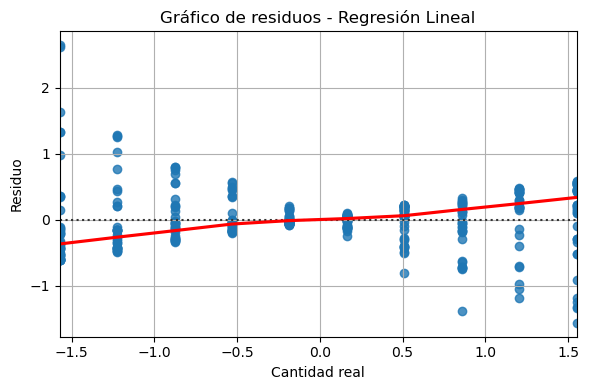

In [111]:
residuals = y_test_g - modelos['LinearRegression'].predict(X_test_g_clean)

plt.figure(figsize=(6, 4))
sns.residplot(x=y_test_g, y=residuals, lowess=True, line_kws={"color": "red"})
plt.title("Gráfico de residuos - Regresión Lineal")
plt.xlabel("Cantidad real")
plt.ylabel("Residuo")
plt.grid(True)
plt.tight_layout()
plt.show()


## Gráfico de residuos (Regresión Lineal)
El gráfico muestra una distribución de errores (residuos) que no es completamente aleatoria, lo que indica que el modelo de regresión lineal no está capturando bien las relaciones no lineales entre las variables. Además, se observa cierta curvatura en la línea de tendencia, lo que sugiere que hay patrones no lineales que este modelo no puede representar adecuadamente. Por tanto, la regresión lineal no es el modelo más adecuado para este problema.

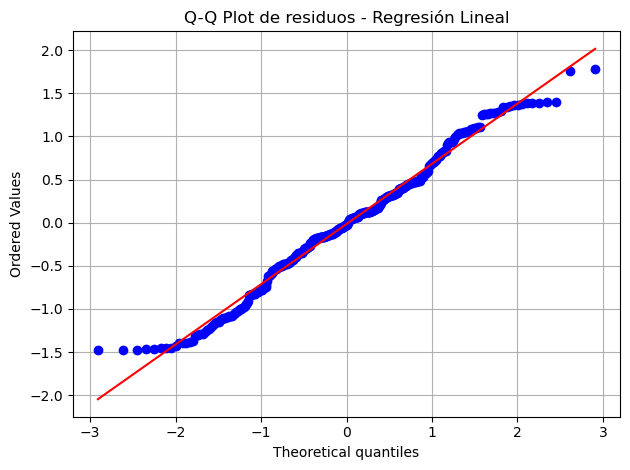

In [112]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot de residuos - Regresión Lineal")
plt.grid(True)
plt.tight_layout()
plt.show()


## Q-Q Plot de residuos (Regresión Lineal)
El gráfico Q-Q muestra que la mayoría de los residuos siguen una línea recta, lo que indica que los errores tienen una distribución aproximadamente normal. Sin embargo, se observan algunas desviaciones en los extremos (colas), lo que sugiere que hay algunos valores atípicos o leves violaciones de la normalidad. A pesar de eso, en general la suposición de normalidad de los residuos se cumple razonablemente bien.

In [113]:
y_train_g = fct_encoded_general.loc[X_train_g.index, 'QUANTITY']
y_test_g = fct_encoded_general.loc[X_test_g.index, 'QUANTITY']


### Arbol de Decisiones

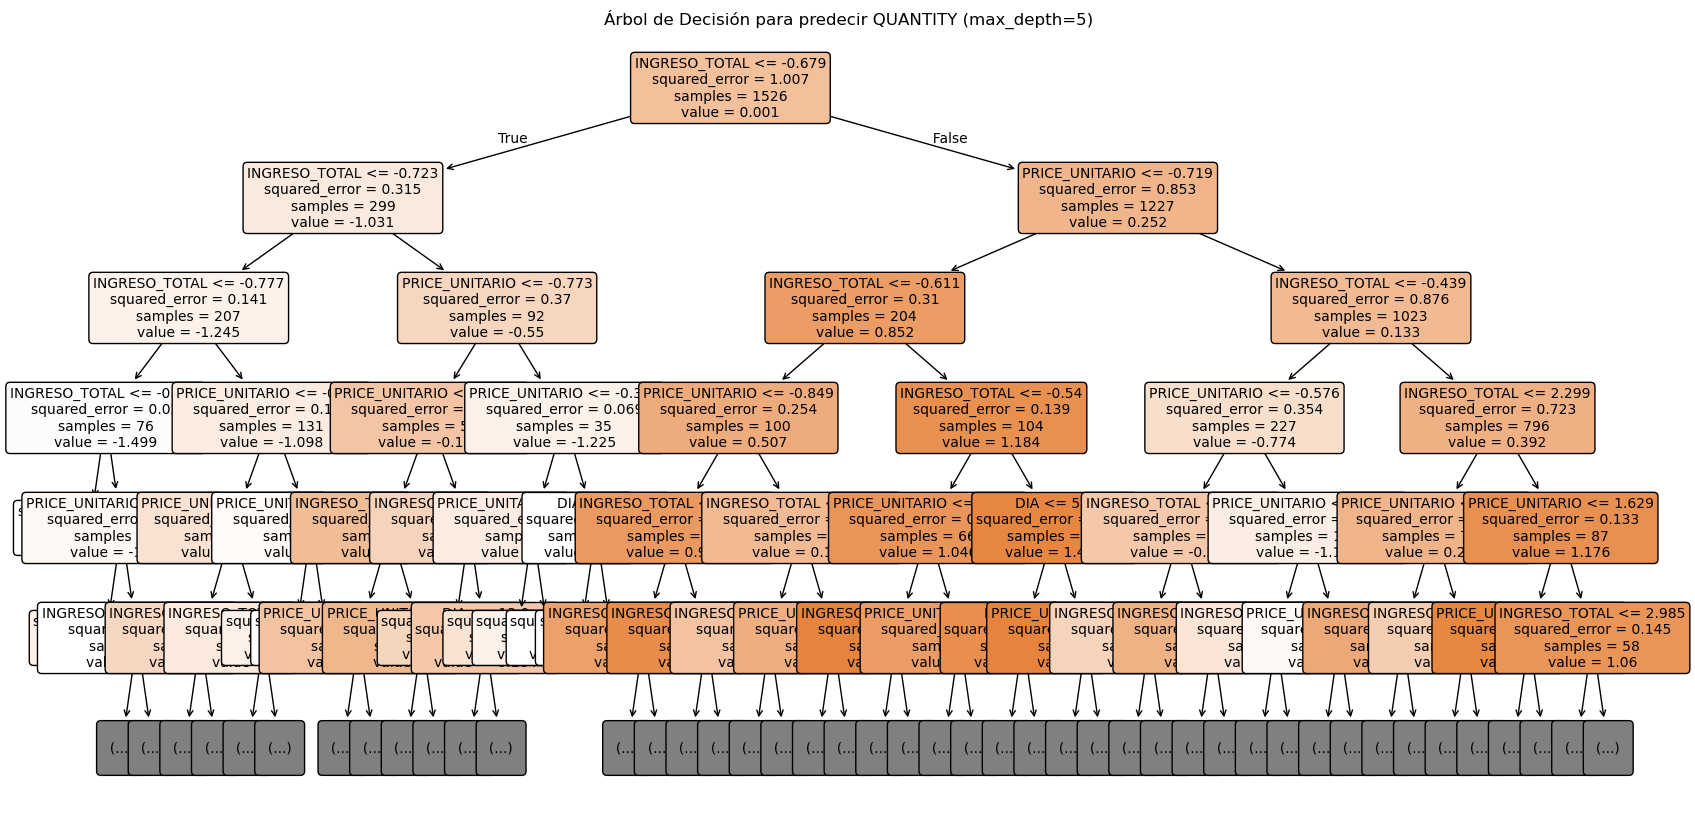

In [114]:

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train_g_clean, y_train_g)

plt.figure(figsize=(20, 10))
plot_tree(
    tree_model,
    feature_names=X_train_g_clean.columns,
    filled=True,
    rounded=True,
    max_depth=5,
    fontsize=10
)
plt.title("Árbol de Decisión para predecir QUANTITY (max_depth=5)")
plt.show()


## Árbol de Decisión
- Objetivo del modelo:
Este árbol fue entrenado para predecir la cantidad de productos vendidos (QUANTITY) en función de otras variables como INGRESO_TOTAL, PRICE_UNITARIO y DIA.

- Variables más utilizadas:
Las variables más relevantes según el árbol son:

INGRESO_TOTAL

PRICE_UNITARIO

DIA (aunque con menos frecuencia)

Esto confirma visualmente lo que indican otras métricas de importancia de variables: que INGRESO_TOTAL y PRICE_UNITARIO influyen fuertemente en la cantidad de unidades vendidas.

- Interpretación de nodos:
Cada nodo muestra:

El criterio de división (<=)

El error cuadrático medio (squared_error) en ese nodo

La cantidad de muestras (samples)

El valor medio predicho (value) para QUANTITY

- Ejemplo:

makefile
Copiar
Editar
INRESO_TOTAL <= -0.723
squared_error = 0.315
samples = 299
value = -1.031
Esto indica que para valores bajos de ingreso total, la cantidad esperada de productos vendidos es más baja.

- Segmentación del mercado:
El árbol está haciendo una clara segmentación del comportamiento de ventas según el ingreso y el precio unitario. Esto puede ayudarte a identificar grupos de productos o condiciones de venta con patrones de compra específicos.

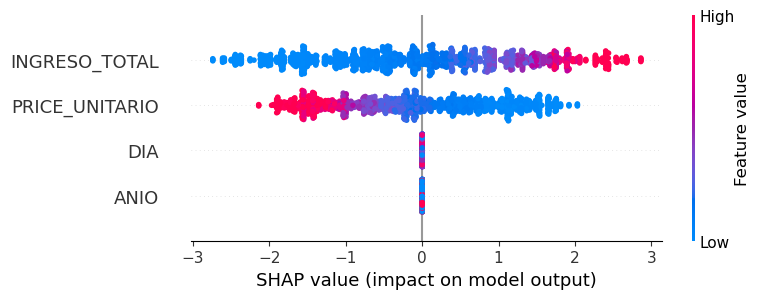

In [115]:

gb_model = modelos['GradientBoosting']
explainer = shap.Explainer(gb_model, X_train_g_clean)
shap_values = explainer(X_train_g_clean)

shap.summary_plot(shap_values, X_train_g_clean)



## SHAP Summary Plot
El gráfico SHAP muestra que las variables INGRESO_TOTAL y PRICE_UNITARIO son las que más impacto tienen en las predicciones del modelo.

Valores altos de INGRESO_TOTAL (color rojo) tienden a aumentar la predicción de la variable objetivo (QUANTITY), mientras que valores bajos (azul) la disminuyen.

En cambio, PRICE_UNITARIO tiene una relación inversa: valores altos suelen disminuir la predicción, y valores bajos aumentarla.

Las variables DIA y ANIO tienen un impacto mínimo, lo que sugiere que su influencia en la predicción de la cantidad vendida es muy baja o nula.

### Curva de aprendizaje

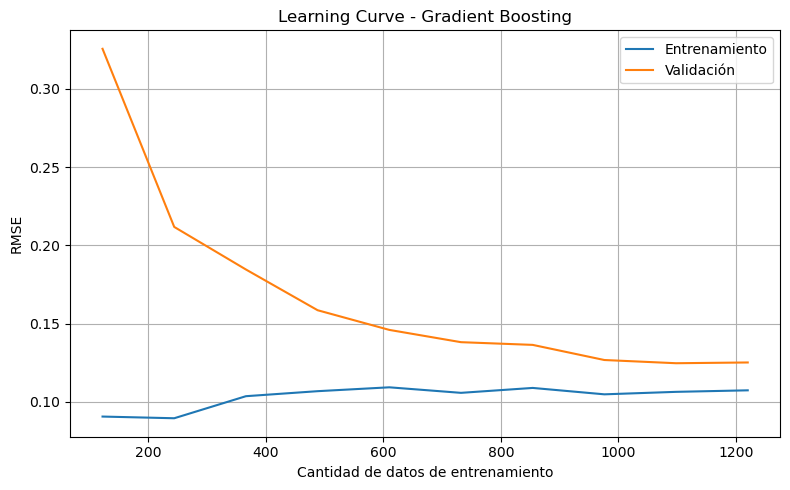

In [116]:
gb_model = modelos['GradientBoosting']
train_sizes, train_scores, test_scores = learning_curve(
    gb_model,
    X_train_g_clean,
    y_train_g,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_rmse = np.sqrt(-train_scores)
test_rmse = np.sqrt(-test_scores)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_rmse.mean(axis=1), label='Entrenamiento')
plt.plot(train_sizes, test_rmse.mean(axis=1), label='Validación')
plt.xlabel("Cantidad de datos de entrenamiento")
plt.ylabel("RMSE")
plt.title("Learning Curve - Gradient Boosting")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Learning Curve del modelo Gradient Boosting

A medida que usamos más datos de entrenamiento, el error de validación (naranja) disminuye y se estabiliza, lo cual indica que el modelo se beneficia de tener más datos.

El error de entrenamiento (azul) es más bajo y se mantiene bastante constante, lo cual sugiere que el modelo está aprendiendo bien sin sobreajustarse.

No hay una gran brecha entre entrenamiento y validación, lo cual es buena señal de bajo overfitting y un buen ajuste general del modelo.

### Visualización: Comparación de y_test vs y_pred (Mejor modelo general)

Mejor modelo general: DecisionTree


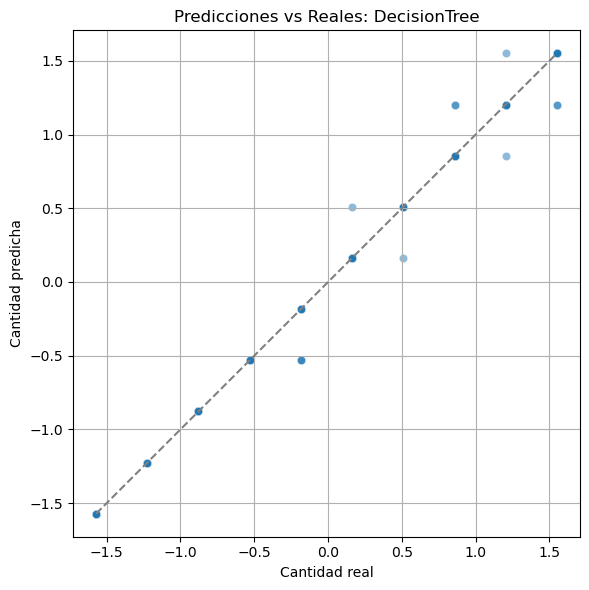

In [117]:

mejor_modelo_nombre = df_general.sort_values('RMSE').iloc[0].name
print("Mejor modelo general:", mejor_modelo_nombre)

modelo = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}[mejor_modelo_nombre]

modelo.fit(X_train_g, y_train_g)
y_pred = modelo.predict(X_test_g)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_g, y=y_pred, alpha=0.5)
plt.plot([y_test_g.min(), y_test_g.max()], [y_test_g.min(), y_test_g.max()], '--', color='gray')
plt.xlabel("Cantidad real")
plt.ylabel("Cantidad predicha")
plt.title(f"Predicciones vs Reales: {mejor_modelo_nombre}")
plt.grid(True)
plt.tight_layout()
plt.show()


## Predicciones vs los valores reales del modelo Decision Tree.

La mayoría de los puntos están alineados cerca de la línea diagonal punteada, lo cual indica que las predicciones del modelo son muy cercanas a los valores reales.

Esto refleja un alto nivel de precisión en la predicción de la variable QUANTITY.

El modelo de árbol de decisión está capturando bien los patrones de los datos sin grandes errores sistemáticos.

##  Análisis por modelo:
- Decision Tree
Mejor desempeño en todas las métricas: MAE, RMSE y R².

Está ajustando muy bien el modelo a los datos de entrenamiento y prueba.


- Random Forest
Muy buen rendimiento, solo ligeramente inferior a Decision Tree.

Menor riesgo de sobreajuste que un árbol individual.

Ideal si buscas robustez y generalización a futuro.

- Gradient Boosting
Significativamente más error (MAE y RMSE más altos).

R² sigue siendo alto, lo que indica que capta la tendencia general pero con menos precisión.

Posible mejora ajustando hiperparámetros (learning rate, n_estimators...).

- Linear Regression
Resultados muy pobres.

R² de apenas 0.49, lo que implica que explica menos del 50% de la variabilidad de la cantidad vendida.

Evidencia clara de que las relaciones en los datos no son lineales.

## Conclusiones Generales:

En este proyecto se desarrolló un modelo de regresión para predecir la cantidad de productos vendidos (QUANTITY) utilizando datos históricos del sistema ERP de la empresa. A partir de la ingeniería de variables y la evaluación de distintos modelos (Regresión Lineal, Árboles de Decisión, Random Forest y Gradient Boosting), se concluyó que los modelos basados en árboles presentan un rendimiento significativamente superior, siendo el Árbol de Decisión el más preciso con un RMSE de 0.035 y un R² de 0.9987. Esta predicción precisa de la demanda permite a la empresa optimizar la planificación de inventario y estrategias comerciales, mejorando la eficiencia operativa y reduciendo costos por sobre o substock.

- Decision Tree y Random Forest son los mejores modelos para este caso.

- Random Forest es más seguro si deseas evitar sobreajuste.

- Gradient Boosting podría mejorar con tuning.

- Linear Regression no es recomendable para este problema.